## Overview

This notebook is a replication of [this](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/04_torch_qgan.html) wonderful tutorial from `qiskit-machine-learning`'s documentation site. This notebook goes through how to build a PyTorch-based Quantum Generative Adversarial Network. 

The goal of this GAN is to learn a 2D multivariate normal distribution.

In [1]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from matplotlib import cm
from qiskit_algorithms.utils import algorithm_globals
from scipy.stats import multivariate_normal, entropy
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.circuit.library import EfficientSU2
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from IPython.display import clear_output

In [2]:
algorithm_globals.random_seed = 1234
_ = torch.manual_seed(1234)

### Generating the target distribution

In [3]:
num_dim = 2
num_discrete_values = 8
num_qubits = num_dim * int(np.log2(num_discrete_values))

coords = np.linspace(-2, 2, num_discrete_values)
rv = multivariate_normal(mean=[0.0, 0.0], cov=[[1, 0], [0, 1]], seed=algorithm_globals.random_seed)
grid_elements = np.transpose([np.tile(coords, len(coords)), np.repeat(coords, len(coords))])
prob_data = rv.pdf(grid_elements)
prob_data /= np.sum(prob_data)

prob_data

array([0.00099208, 0.00264229, 0.00507693, 0.00703739, 0.00703739,
       0.00507693, 0.00264229, 0.00099208, 0.00264229, 0.00703739,
       0.01352173, 0.01874316, 0.01874316, 0.01352173, 0.00703739,
       0.00264229, 0.00507693, 0.01352173, 0.02598084, 0.03601337,
       0.03601337, 0.02598084, 0.01352173, 0.00507693, 0.00703739,
       0.01874316, 0.03601337, 0.04991995, 0.04991995, 0.03601337,
       0.01874316, 0.00703739, 0.00703739, 0.01874316, 0.03601337,
       0.04991995, 0.04991995, 0.03601337, 0.01874316, 0.00703739,
       0.00507693, 0.01352173, 0.02598084, 0.03601337, 0.03601337,
       0.02598084, 0.01352173, 0.00507693, 0.00264229, 0.00703739,
       0.01352173, 0.01874316, 0.01874316, 0.01352173, 0.00703739,
       0.00264229, 0.00099208, 0.00264229, 0.00507693, 0.00703739,
       0.00703739, 0.00507693, 0.00264229, 0.00099208])

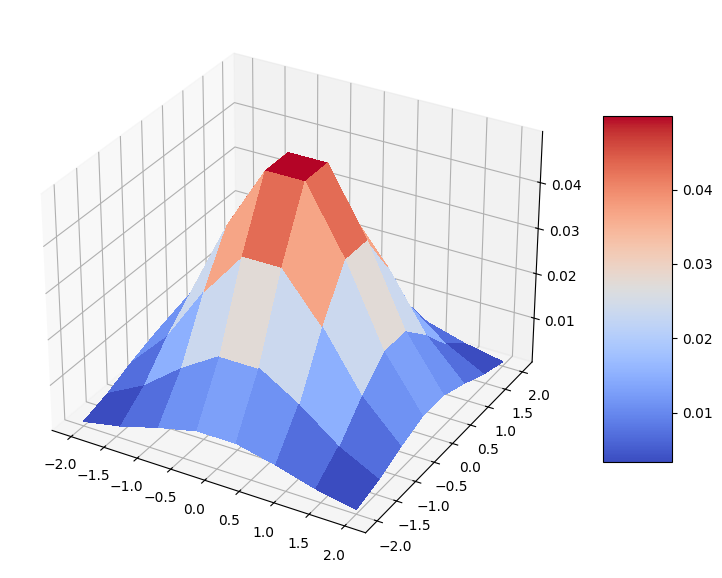

In [4]:
mesh_x, mesh_y = np.meshgrid(coords, coords)
grid_shape = (num_discrete_values, num_discrete_values)

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "3d"})
prob_grid = np.reshape(prob_data, grid_shape)
surf = ax.plot_surface(mesh_x, mesh_y, prob_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### Defining the Neural Network

#### Quantum neural network ansatz

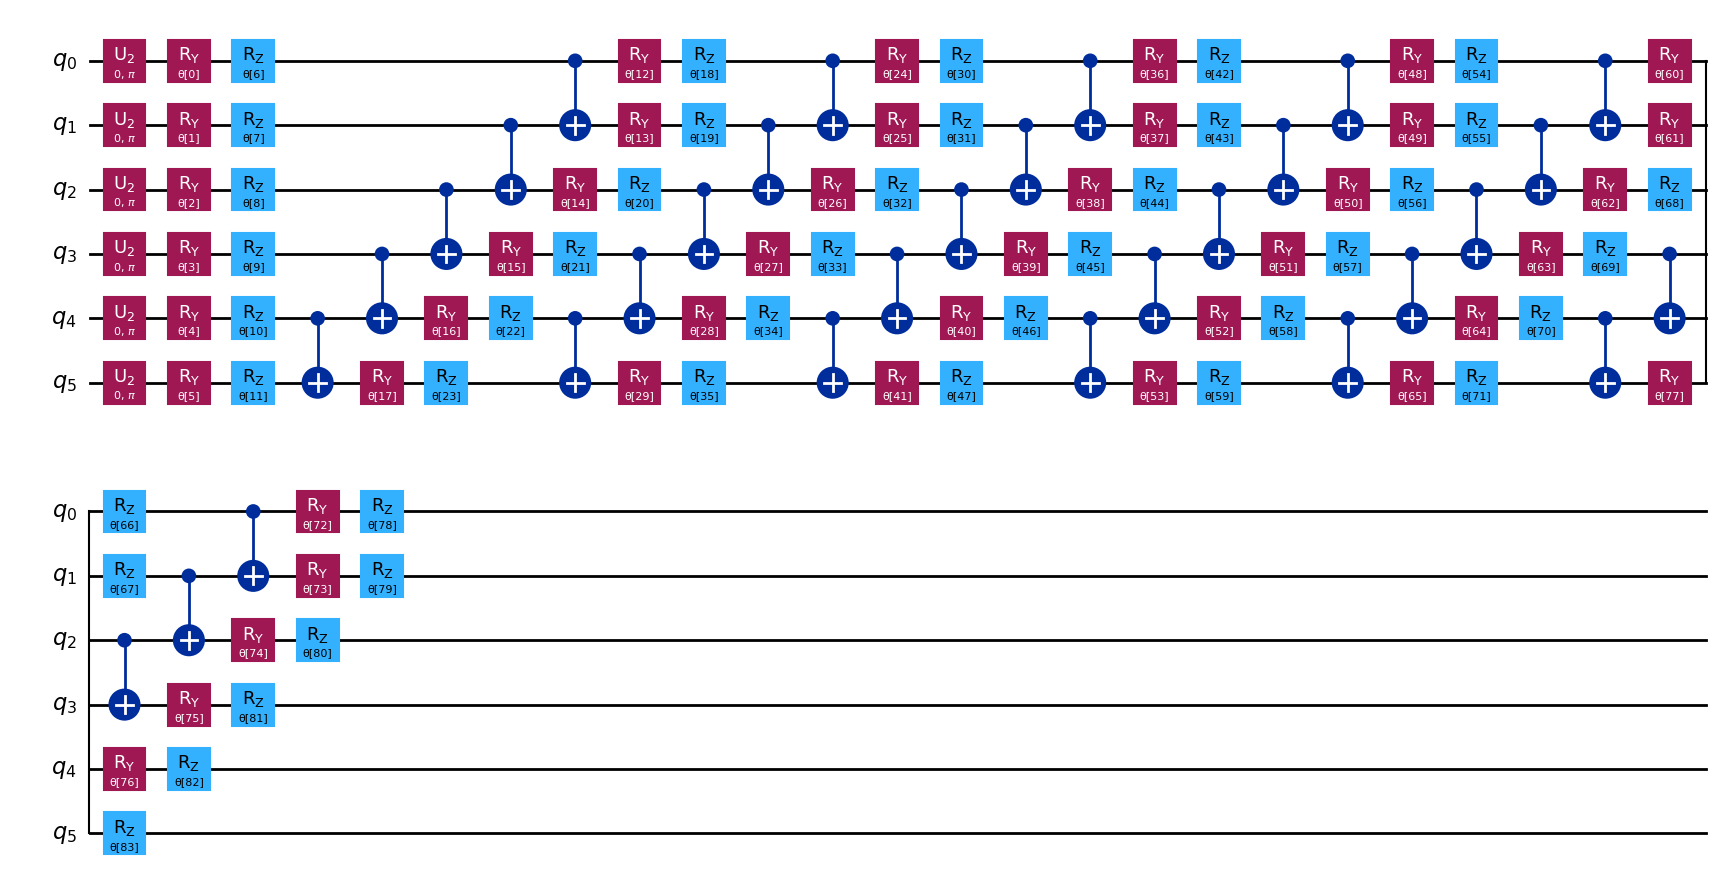

In [5]:
qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = EfficientSU2(num_qubits, reps=6)
qc.compose(ansatz, inplace=True)
qc.decompose().draw('mpl')

In [7]:
print(qc.num_parameters)

84


AttributeError: 'QuantumCircuit' object has no attribute 'num_weight_parameters'

### Quantum generator

In [ ]:
shots = 10000
sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)

### Classical discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        
        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

## Set up the training loop

In [ ]:
generator = create_generator()
discriminator = Discriminator(num_dim)

### Loss function

In [ ]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

### Optimizers

In [ ]:
lr = 0.01  # learning rate
b1 = 0.7   # first momentum parameter
b2 = 0.999 # second momentum parameter

generator_optim = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optim = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)

### Training process

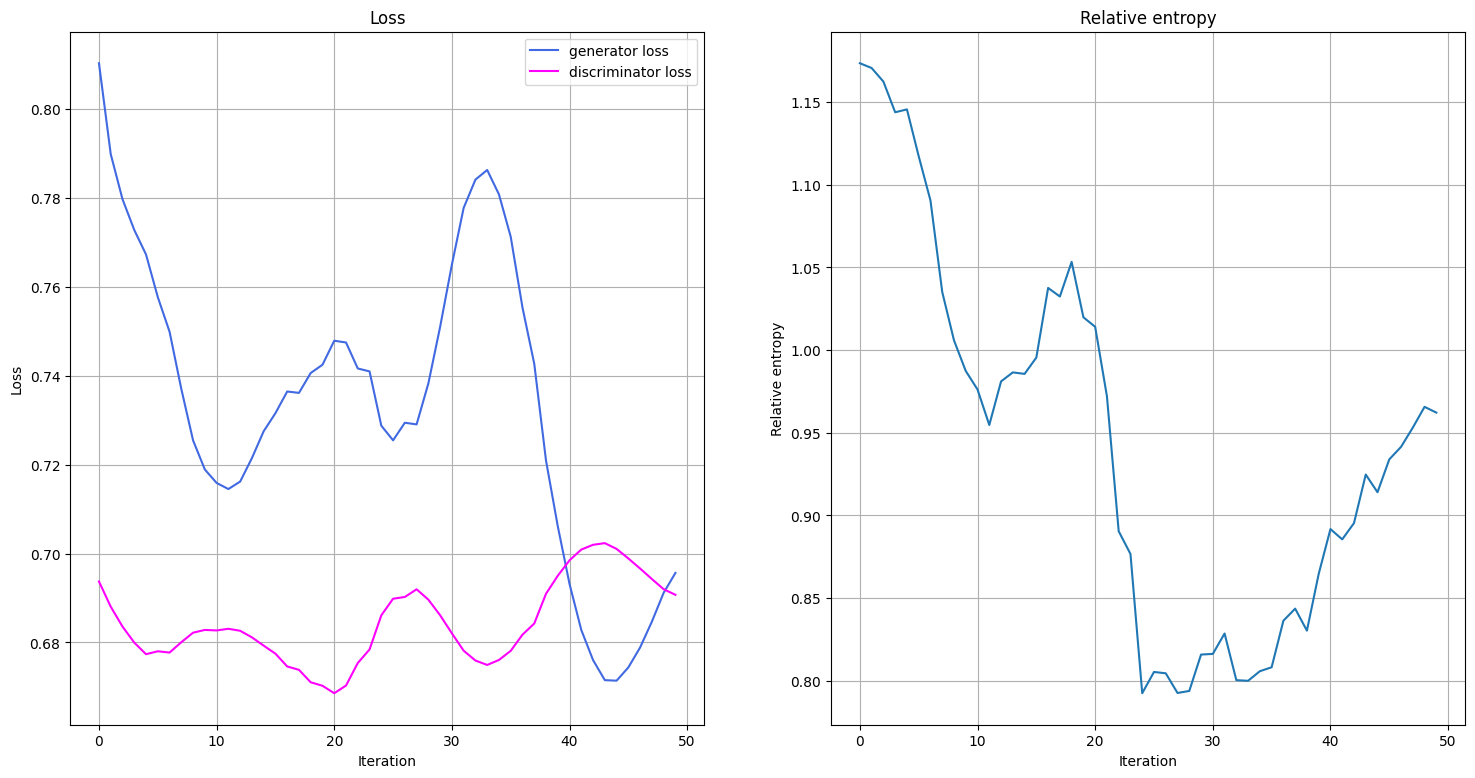

Trained in 38.19 seconds


In [ ]:
def plot_training_progress(generator_loss_values, discriminator_loss_values, entropy_values):
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend()
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()
    
    plt.show()


n_epochs = 50

num_qnn_outputs = num_discrete_values ** num_dim
generator_loss_values, discriminator_loss_values, entropy_values = [], [], []

start = time.time()

for epoch in range(n_epochs):
    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Configure input
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Configure samples
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_values = discriminator(samples)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Train generator
    generator_optim.zero_grad()
    generator_loss = adversarial_loss(disc_values, valid, gen_dist)

    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optim.step()
    
    # Train discriminator
    discriminator_optim.zero_grad()

    real_loss = adversarial_loss(disc_values, valid, real_dist)
    fake_loss = adversarial_loss(disc_values, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optim.step()
    
    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
    entropy_values.append(entropy_value)

    plot_training_progress(generator_loss_values, discriminator_loss_values, entropy_values)

elapsed = time.time() - start
print(f"Trained in {elapsed:0.2f} seconds")

## Visualising the results

In [ ]:
with torch.no_grad():
    generated_probabilities = generator().numpy()

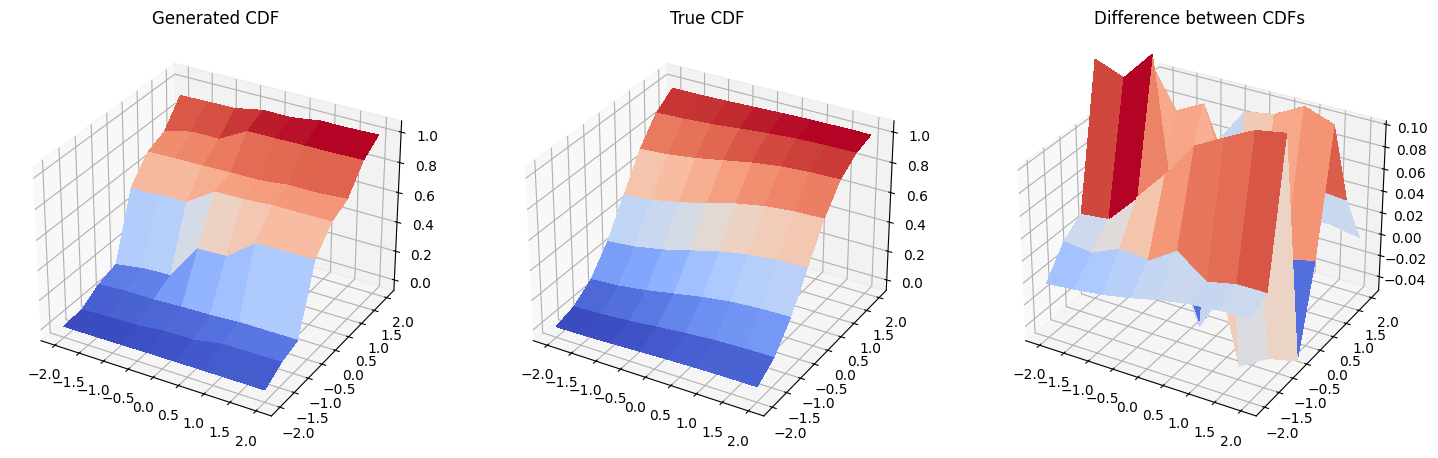

In [ ]:
fig = plt.figure(figsize=(18, 9))

# Generated CDF
gen_prob_grid = np.reshape(np.cumsum(generated_probabilities), grid_shape)

ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax1.set_title("Generated CDF")
ax1.plot_surface(mesh_x, mesh_y, gen_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax1.set_zlim(-0.05, 1.05)

# Real CDF
real_prob_grid = np.reshape(np.cumsum(prob_data), grid_shape)

ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.set_title("True CDF")
ax2.plot_surface(mesh_x, mesh_y, real_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax2.set_zlim(-0.05, 1.05)

# Difference
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.set_title("Difference between CDFs")
ax3.plot_surface(
    mesh_x, mesh_y, real_prob_grid - gen_prob_grid, linewidth=2, antialiased=False, cmap=cm.coolwarm
)
ax3.set_zlim(-0.05, 0.1)
plt.show()